<a href="https://colab.research.google.com/github/santiagocasas/notebooks/blob/master/Corona_Fr_It.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [0]:
from datetime import datetime,timedelta

In [0]:
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

Extract data from https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases 


In [0]:
#url="https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_19-covid-Confirmed.csv"
corona_cases_df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/data-preview.csv', index_col=[0,1,2,3])

In [0]:
datesformatted = [datetime.strptime(da, '%m/%d/%y') for da in corona_cases_df.columns.values]

In [0]:
daterange = pd.DatetimeIndex(datesformatted)

In [51]:
daterange

DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
               '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
               '2020-02-07', '2020-02-08', '2020-02-09', '2020-02-10',
               '2020-02-11', '2020-02-12', '2020-02-13', '2020-02-14',
               '2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18',
               '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22',
               '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26',
               '2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01',
               '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05',
               '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09',
               '2020-03-10'],
              dtype='datetime64[ns]', freq=None)

In [0]:
country_official_list = (corona_cases_df.index.get_level_values('Country/Region').values)

In [53]:
countries_list = np.unique(np.array([s for s in country_official_list if "Korea" in s or 'China' in s or 'Italy' in s or 'France' in s]))
countries_list

array(['France', 'Italy', 'Mainland China', 'Republic of Korea'],
      dtype='<U17')

In [0]:
cases_percountry = {}
df_dict = {}

In [0]:
for country in countries_list:
    cou = corona_cases_df.loc[pd.IndexSlice[:, country], :].sum()
    cases_percountry[country] = cou[cou > 0]
    datesformat = [datetime.strptime(da, '%m/%d/%y') for da in cases_percountry[country].index]
    df_dict[country] = pd.DataFrame(cases_percountry[country], columns=['Cases'], index=datesformat)
    df_dict[country]['DayCount'] = np.arange(1,cases_percountry[country].shape[0]+1)


In [56]:
df_dict['Italy']['Cases'][0:-1:5]  #print every 5 days

2020-01-31       2
2020-02-05       2
2020-02-10       3
2020-02-15       3
2020-02-20       3
2020-02-25     322
2020-03-01    1694
2020-03-06    4636
Name: Cases, dtype: int64

In [57]:
countries_list

array(['France', 'Italy', 'Mainland China', 'Republic of Korea'],
      dtype='<U17')

France
Italy
Mainland China
Republic of Korea


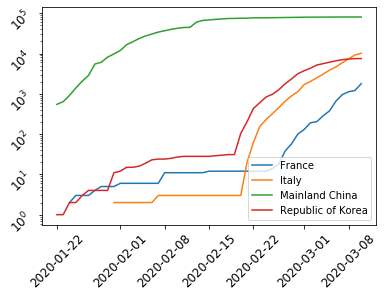

In [58]:
for country in countries_list:
    print(country)
    plt.semilogy(df_dict[country].index, np.array(list(df_dict[country]['Cases'].values)), label=country)
    plt.legend(loc='lower right')
    plt.tick_params(rotation=45, labelsize=12)
plt.show()

# Models

In [0]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In [0]:
def expo_model(x,p,N0=3,x0=1):
    return N0*(1+p)**(x-x0)


## Italy

In [61]:
c_pars = {}
for country in countries_list:
    print('***')
    print(country)
    x = np.array(list(df_dict[country]['DayCount'].values))
    y = np.array(list(df_dict[country]['Cases'].values))

    fit_logi = curve_fit(logistic_model,x,y,p0=[4,60,20000])
        
    ai,bi,ci = fit_logi[0]
    sigma_ai, sigma_bi, sigma_ci = np.sqrt(np.diag(fit_logi[1]))

    c_pars[(country,'a')] = ai
    c_pars[(country,'b')] = bi
    c_pars[(country,'c')] = ci
    c_pars[(country,'sga')] = sigma_ai
    c_pars[(country,'sgb')] = sigma_bi
    c_pars[(country,'sgc')] = sigma_ci

    print('Logistic Model')
    print([ss+'='+'{:.3f}'.format(xx) for ss, xx in zip(('a','b','c'),(ai,bi,ci))])
    sol = int(fsolve(lambda x : logistic_model(x,ai,bi,ci) - int(ci),bi))
    print('Day of flattening of the infection curve')
    datesol = datetime.strftime(df_dict[country].index[0] + timedelta(days=sol), ' %d, %b %Y' )
    print('--->'+datesol)
    
    c_pars[(country,'asy')] = sol


    y0 = y[0]
    print(y0)

    c_pars[(country,'y0')] = y0

    fit_exp = curve_fit((lambda d,y: expo_model(d,y,N0=y0)),x,y,p0=[0.10])
    pi, sigma_pi = fit_exp[0][0], np.sqrt(fit_exp[1]).flatten()[0]
    print('Exponential Model')
    print([ss+'='+'{:.3f}'.format(xx) for ss, xx in zip(('p','sigma_p'),(pi,sigma_pi))])

    c_pars[(country,'p')] = pi
    c_pars[(country,'sgp')] = sigma_pi

    



***
France
Logistic Model
['a=2.785', 'b=47.609', 'c=3847.302']
Day of flattening of the infection curve
---> 06, Apr 2020
2
Exponential Model
['p=0.152', 'sigma_p=0.001']
***
Italy
Logistic Model
['a=3.628', 'b=40.808', 'c=23262.193']
Day of flattening of the infection curve
---> 23, Apr 2020
2
Exponential Model
['p=0.247', 'sigma_p=0.000']
***
Mainland China
Logistic Model
['a=4.492', 'b=18.744', 'c=80755.757']
Day of flattening of the infection curve
---> 01, Apr 2020
547
Exponential Model
['p=0.122', 'sigma_p=0.003']
***
Republic of Korea
Logistic Model
['a=2.792', 'b=40.374', 'c=7912.626']
Day of flattening of the infection curve
---> 28, Mar 2020
1
Exponential Model
['p=0.213', 'sigma_p=0.001']


## Plot predictions vs. data

In [62]:
countries_list

array(['France', 'Italy', 'Mainland China', 'Republic of Korea'],
      dtype='<U17')

In [0]:
pd.date_range(start=df_dict[country].index[0], periods=c_pars[(country,'asy')]);

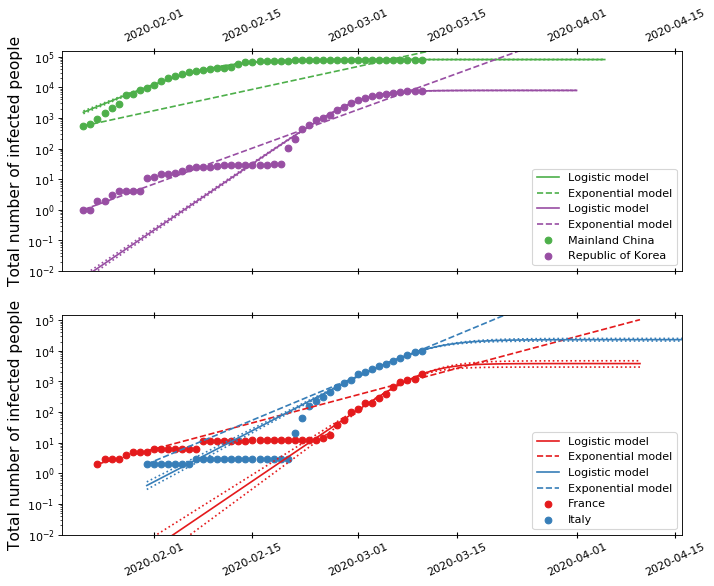

In [64]:

color_list = plt.cm.Set1( np.linspace(0.,1.0, 9 ) )

color_iter = iter(color_list)

fig=plt.figure(1, figsize=(10,8), dpi=80,facecolor='w')

#simulation_box_size = 3000   #the larger the size, the smaller sampling errors at large scales

axes = fig.subplots(2, sharex=True, sharey=True)

for country in countries_list:

    c=next(color_iter)
    if country=="Mainland China" or country=="Republic of Korea":
        ax = axes[0]
    else:
        ax = axes[1]

    x = np.array(list(df_dict[country]['DayCount'].values))
    y = np.array(list(df_dict[country]['Cases'].values))

    flatasymp = c_pars[(country,'asy')]+5

    pred_x = np.arange(np.min(x),flatasymp+np.min(x))

    pred_date = pd.date_range(start=df_dict[country].index[0], periods=flatasymp).values#  np.arange(np.min(x),66+np.min(x))
    #plt.rcParams['figure.figsize'] = [7, 7] np.min(x)
    #plt.rc('font', size=14)# Real data
    
    #ax.scatter(x,y_fr,label="Data FR",color="blue")# Predicted logistic curve
    #ax.plot(pred_x, [logistic_model(i,af,bf,cf) for i in pred_x], label="Logistic model", color='blue' )# Predicted exponential curve
    #plt.plot(pred_x, [logistic_model(i,af+sigma_af,bf,cf+sigma_cf) for i in pred_x], ':', label="Logistic model", color='blue' )# Predicted exponential curve
    #ax.plot(pred_x, [expo_model(i,fit_fr_exp[0][0], N0=N0_fr) for i in pred_x], '--', label="Exponential model", color='darkviolet' )

    ax.scatter(df_dict[country].index ,y ,label=country,color=c)# Predicted logistic curve

    ai = c_pars[(country,'a')]

    ax.semilogy(pred_date, [logistic_model(i,c_pars[(country,'a')],
                                        c_pars[(country,'b')],
                                        c_pars[(country,'c')]) for i in pred_x], label="Logistic model", color=c)  #Predicted Logistic Curve
    ax.plot(pred_date, [logistic_model(i,c_pars[(country,'a')]+c_pars[(country,'sga')],
                                      c_pars[(country,'b')]+c_pars[(country,'sgb')],
                                      c_pars[(country,'c')]+c_pars[(country,'sgc')]) for i in pred_x], ':', color=c )# Confidence contour
    ax.plot(pred_date, [logistic_model(i,c_pars[(country,'a')]-c_pars[(country,'sga')],
                                      c_pars[(country,'b')]-c_pars[(country,'sgb')],
                                      c_pars[(country,'c')]-c_pars[(country,'sgc')]) for i in pred_x], ':', color=c )# Confidence contour

    #c=next(color_iter)

    ax.plot(pred_date, [expo_model(i,c_pars[(country,'p')], N0=c_pars[(country,'y0')]) for i in pred_x], '--',label="Exponential model", color=c)
    #plt.plot(x+pred_x, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x], label="Exponential model" )plt.legend()
    #ax.set_xlabel("Days since 1 January 2020", fontsize=16)
    ax.set_ylabel("Total number of infected people", fontsize=14)
    axes[1].tick_params(axis='x', direction='inout', length=6, width=1,
                  grid_color='k', grid_alpha=0.8, rotation=25, top=True, labeltop=False)
    axes[0].tick_params(axis='x', direction='inout', length=6, width=1,
                  grid_color='k', grid_alpha=0.8, rotation=25, top=True, labeltop=True)
    ax.legend(loc='lower right')
    ax.set_xlim([pred_date[0]-np.timedelta64(3,'D'), pred_date[-1]+np.timedelta64(15,'D')])
    ax.set_ylim(0.01, 150000)##  (min(y_fr)*0.8  max(cf,ci)*1.1))
    #fig.show()